# Methods Walkthrough
This notebook will walkthrough the methods to generate the population level comparison between acoustic and neural data

## Panel 1: UMAP of Acoustic signals

For this panel, I take the entire `vocParamTable.h5` and extract Biosound features of each signal. These features include: 'sal', 'fund','maxfund','minfund','cvfund','meanS', 'stdS', 'skewS', 'kurtS', 'entS', 'q1', 'q2', 'q3','meanT', 'stdT', 'skewT', 'kurtT', 'entT','rms', 'maxAmp'.

zscoring all of these variables, I then pass them through a cluster_analysis pipeline. This includes first taking the UMAP of the input data, then creating a dendrogram using the 'ward' distance metric, using that dendrogram, I traverse 500 cuts from the dendrogram, and calculate the ARI based on the GT labels. The best ARI is reported. The plot is made from the UMAP components (first two) and colored based on call type.


The generation of the dataset can be found [here](https://github.com/theunissenlab/zebra-finch-categories/blob/main/notebooks/EPHYS1-Generate_Dataframes.ipynb )

The clustering code can be found [here](https://github.com/theunissenlab/zebra-finch-categories/blob/main/code/cluster_functions.py)

/auto/fhome/lthomas/.virtualenvs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


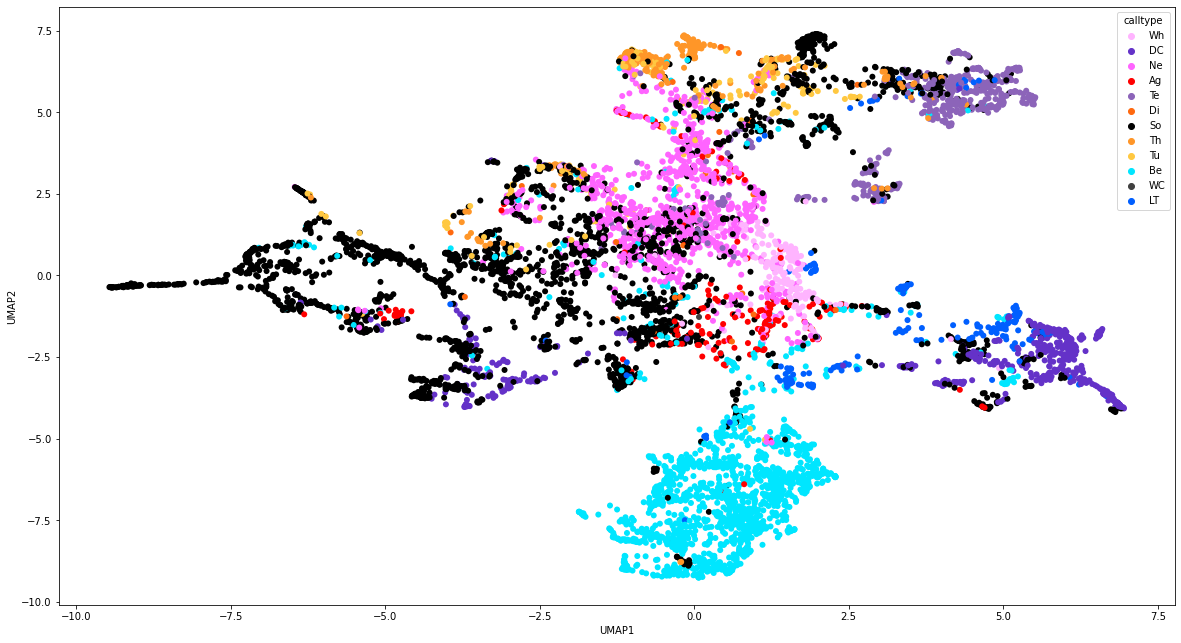

In [19]:
import pandas as pd
import pickle as pk
import numpy as np 
import seaborn
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
import matplotlib.pyplot as plt

callColor = {
        'Be':(0/255.0, 230/255.0, 255/255.0),
        'Tu':(255/255.0, 200/255.0, 65/255.0),
        'Th':(255/255.0, 150/255.0, 40/255.0),
        'Alarm':(255/255.0, 200/255.0, 65/255.0),
        'Di':(255/255.0, 105/255.0, 15/255.0),
        'Ag':(255/255.0, 0/255.0, 0/255.0),
        'Fight':(255/255.0, 105/255.0, 15/255.0),
        'Wh':(255/255.0, 180/255.0, 255/255.0),
        'Ne':(255/255.0, 100/255.0, 255/255.0),
        'Te':(140/255.0, 100/255.0, 185/255.0),
        'Soft':(255/255.0, 180/255.0, 255/255.0),
        'DC':(100/255.0, 50/255.0, 200/255.0),
        'LT':(0/255.0, 95/255.0, 255/255.0),
        'Loud':(100/255.0, 50/255.0, 200/255.0),
        'song':(0, 0, 0),
        'So':(0,0,0), 
        'In': (0.49,0.60,0.55), 
        'Mo':(0.69,0.39,0.39),
        'Ri':(0,255/255.0,0),
        'WC': (.25, .25, .25)}
acoustic_clustering = pd.read_hdf('/auto/zdrive/lthomas/FullVocBank_2020/vocParamTable_clusters.h5','clusters')
umaps_tot = np.asarray([acoustic_clustering.umap1, acoustic_clustering.umap2]).T
acoustic_clustering.head(5)
plt.figure(figsize=(20,11))
seaborn.scatterplot(umaps_tot[:,0],umaps_tot[:,1],acoustic_clustering.calltype,palette=callColor,edgecolors=None,linewidth=0)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.savefig("Figs/UMAP_plot.png")

## FET Questions/Suggestions: 
1. The WC are the the copulation whines - right?  I don't think we have many of these - theu should be light grey (I think).  I would delete or combine with Wh?  
2.  We should make an nice EPS of these that we can label on the graph (Instead of the color legend) - and show little spectrogram examples...
3. I wonder if male and female DC would not split up nicely... There are a bunch of DC by song around UMAP -5.0 to -2.5 - maybe those are all male DCs??
4. Same as above we could try to separate the song syllables into Intro notes vs Motif nNotes.
5. I wonder if we should think about some quantification of how good this representation is.  For example, we could compare the ARI to call types with an HAC based on the UMAP embedding vs PCA embedding?  I am sure that folks have addressed this?  Also maybe we need to compare classic HAC vs HDBSCAN?

## Panel 2: UMAP colored by xy

This is quite simply coloring the above plot by the points are colored according to RGB(.5,Norm_x,Norm_y)


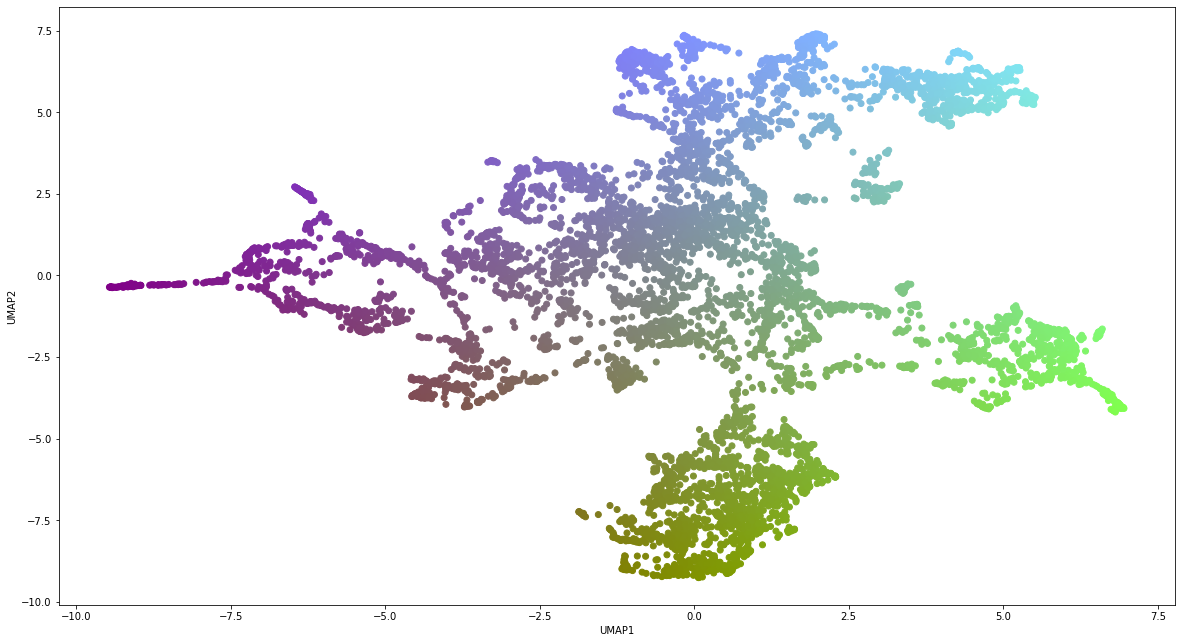

In [16]:

norm_aud_umaps = (c - np.min(c,axis=0))/(np.max(c,axis=0)-np.min(c,axis=0))
aud_ab = (norm_aud_umaps*255).astype(np.int) - 128
aud_lab = []
for ab in norm_aud_umaps:
    aud_lab.append([.5,ab[0],ab[1]])
aud_lab = np.asarray(aud_lab)
plt.figure(figsize=(20,11))
plt.scatter(umaps_tot[:,0],umaps_tot[:,1],c=aud_lab)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.savefig("Figs/UMAP_plot_xycolor.png")

## FET Comments
Looks good but see below - maybe we do this analysis a different way?

## Panel 3: Individual grouping analysis

Code can be seen [here](https://github.com/theunissenlab/zebra-finch-categories/blob/main/notebooks/Supplementary%20Calculations.ipynb) 

First I load HerminaDatabase GoodUnitPC pkl files for all the groupings. For each grouping size, I pull all the groupings of that size, and pull the rows from HerminaDatabase for each site in the grouping.  

Then, in parallel, for each grouping, I generate an array (z,pc1,pc2,...,pc5) for each stim based on this groupings pcs (from the GoodUnitPC files). Then I run the [cluster analysis](https://github.com/theunissenlab/zebra-finch-categories/blob/main/code/cluster_functions.py) on that, comparing against the call type labels.

I then plot the x,y based on umap projection of neural data, and color based on first the call types, and second the x,y positon of the stimuli above.

In [22]:
# First load the data
dbHermina = pd.read_pickle('../data/ephys_Germany/HerminaDatabase.')

numUnits = [1, 2, 3, 4, 5, 10, 20]
groupings = []
pcc = []
confMat = []
dataPath = '/auto/zdrive/lthomas/Code/zebra-finch-categories/data/ephys_Germany/'
for nUnit in numUnits:
    inPath = dataPath + 'HerminaDatabase%dGoodUnitPC.pkl' % nUnit
    fileIn = open(inPath,"rb")
    # groupings
    groupings.append(pk.load(fileIn))
    # conf matricies
    confMat.append(pk.load(fileIn))
    # percent correct scores for each grouping
    pcc.append(pk.load(fileIn))
    fileIn.close()
    
# load wav file info
pdsegTable = pd.read_hdf("../data/ephys/StimSegTable.h5",'stim_seg')

# get call type info from stim name
stims = np.unique(dbHermina.stim)
has_wavs = np.zeros(len(stims),dtype=np.bool)
identities_orig = [x.split('_')[0] for x in stims]
calltypes_orig = [x.split('_')[2] for x in stims]

# get umaps for stims in the order that was used
aud_pcs = []
aud_umaps = []
lbls = []
aud_lbl_pc = []
aud_lbl_umap = []
for si, stim in enumerate(stims):
    # remove _fs25k.wav
    stim = stim[:-10]
    wavs = pdsegTable[pdsegTable.stimname==stim].sort_values('start')
    if len(wavs):
        first_wav = wavs.iloc[0]
        has_wavs[si] = 1
        aud_row = acoustic_clustering[acoustic_clustering.filenames == first_wav.wav].iloc[0]
        lbls.append(aud_row.calltype)
        aud_lbl_pc.append(aud_row.groups_pca)
        aud_lbl_umap.append(aud_row.groups_umap)
        aud_pcs.append([aud_row.pca1, aud_row.pca2])
        aud_umaps.append([aud_row.umap1, aud_row.umap2])
    else:
        has_wavs[si] = 0
        print("Stim: %s \t Wav: MISSING"%stim)
aud_pcs = np.asarray(aud_pcs)
aud_umaps = np.asarray(aud_umaps)

# norm the umaps from 0 to 1 (relative to all umaps) for visualization 
norm_aud_umaps = (aud_umaps - np.min(umaps_tot,axis=0))/(np.max(umaps_tot,axis=0)-np.min(umaps_tot,axis=0))
aud_ab = (norm_aud_umaps*255).astype(np.int) - 128
aud_lab = []
for ab in norm_aud_umaps:
    aud_lab.append([.5,ab[0],ab[1]])
aud_lab = np.asarray(aud_lab)

Stim: BlaLbl8026_FAS_Wh_1-8-6 	 Wav: MISSING
Stim: BlaLbl8026_FAS_Wh_4-7-3 	 Wav: MISSING
Stim: BlaLbl8026_FAS_Wh_5-9-2 	 Wav: MISSING
Stim: GraLbl0457_MAS_Di_0 	 Wav: MISSING
Stim: GraLbl0457_MAS_Di_1 	 Wav: MISSING
Stim: GraLbl0457_MAS_Ne_3-6-7 	 Wav: MISSING
Stim: GraLbl0457_MAS_Wh_4-9-1 	 Wav: MISSING
Stim: GraLbl0457_MAS_Wh_5-2-8 	 Wav: MISSING
Stim: GraLbl0457_MAS_Wh_6-7-3 	 Wav: MISSING
Stim: LblGre0001_UCF_Be_0 	 Wav: MISSING
Stim: WhiWhi1415_FAF_Ne_1-3-8 	 Wav: MISSING
Stim: WhiWhi1415_FAF_Ne_2-6-5 	 Wav: MISSING


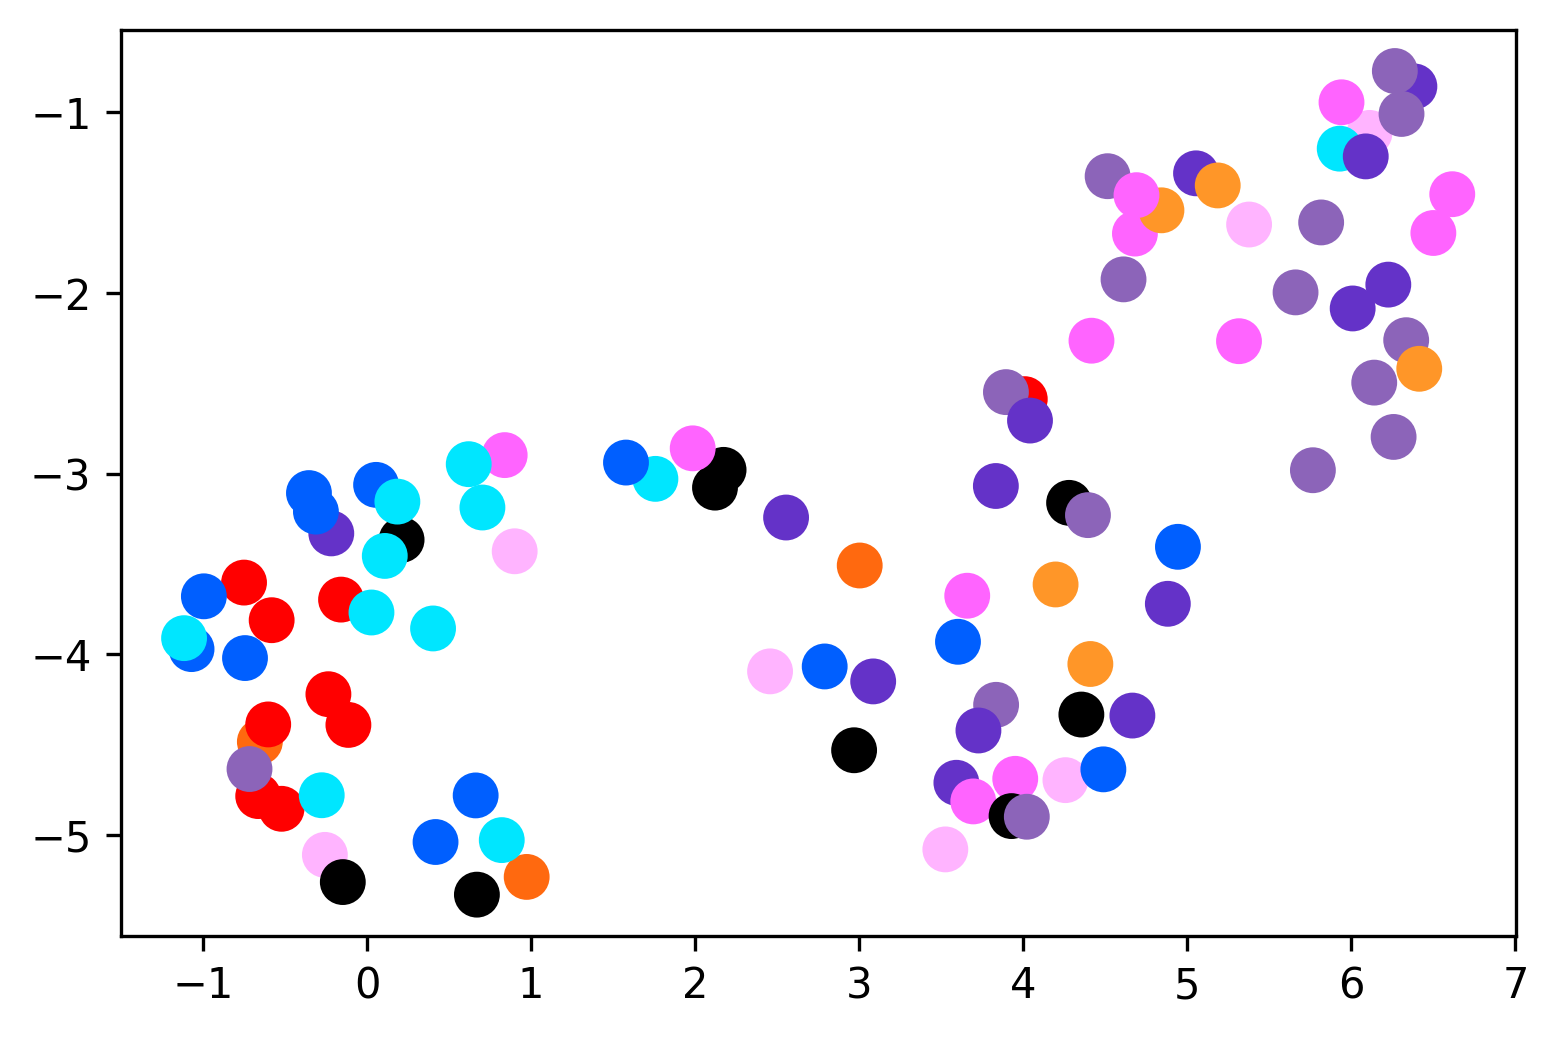

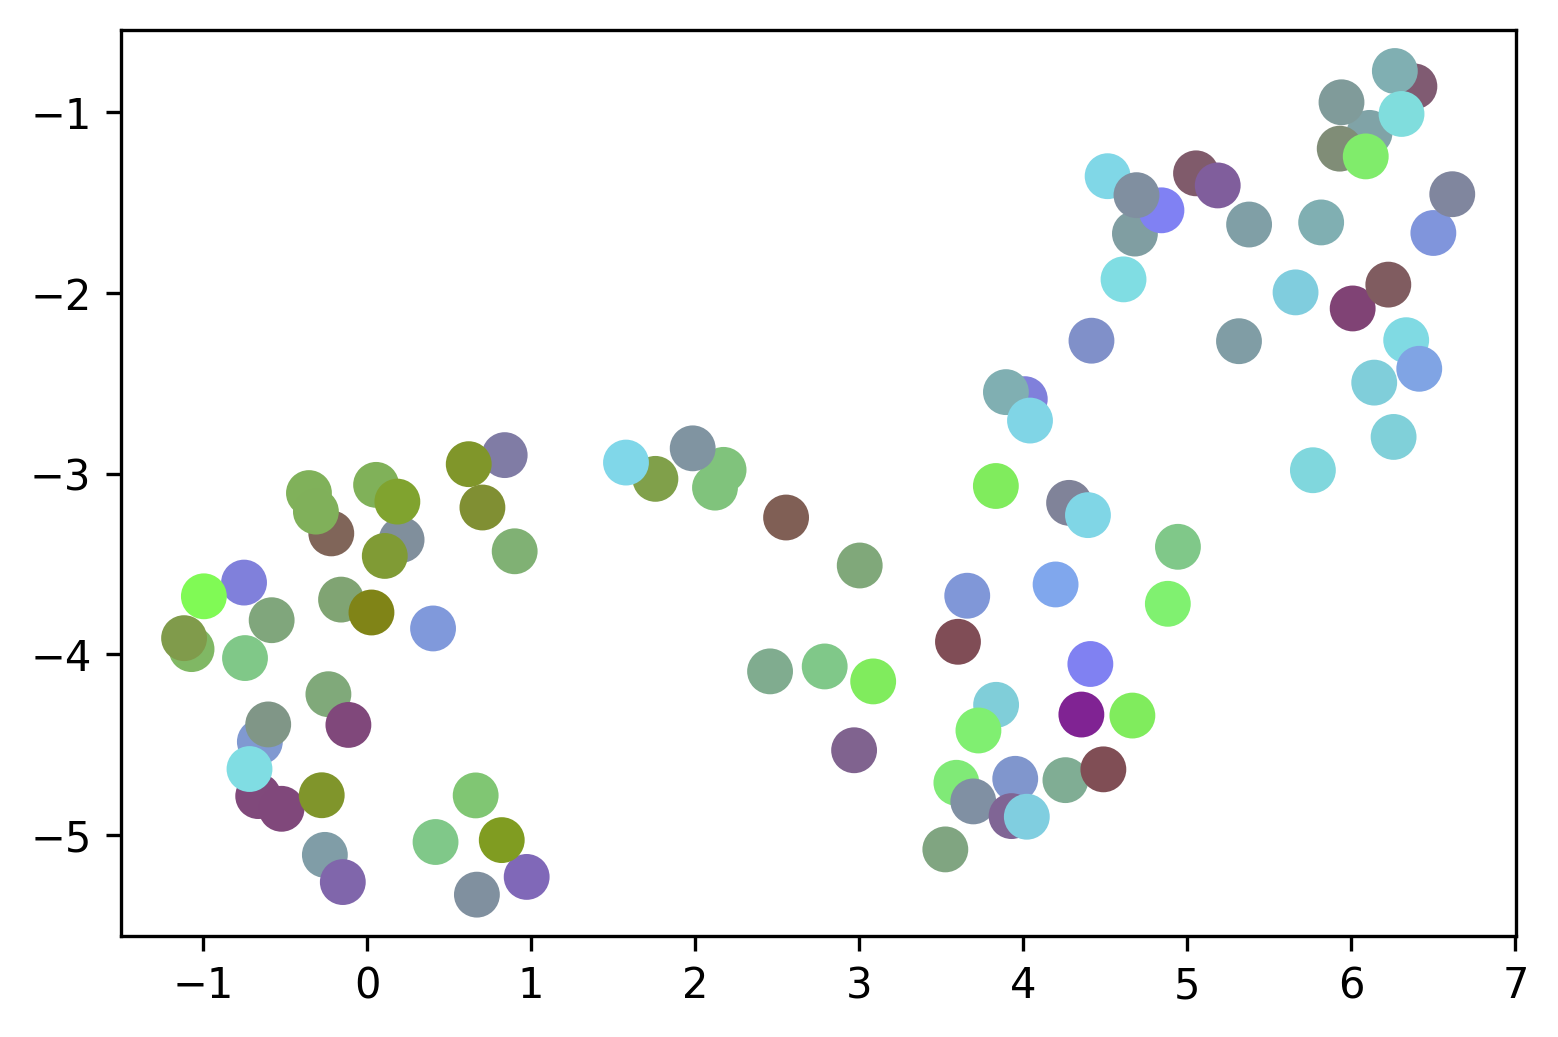

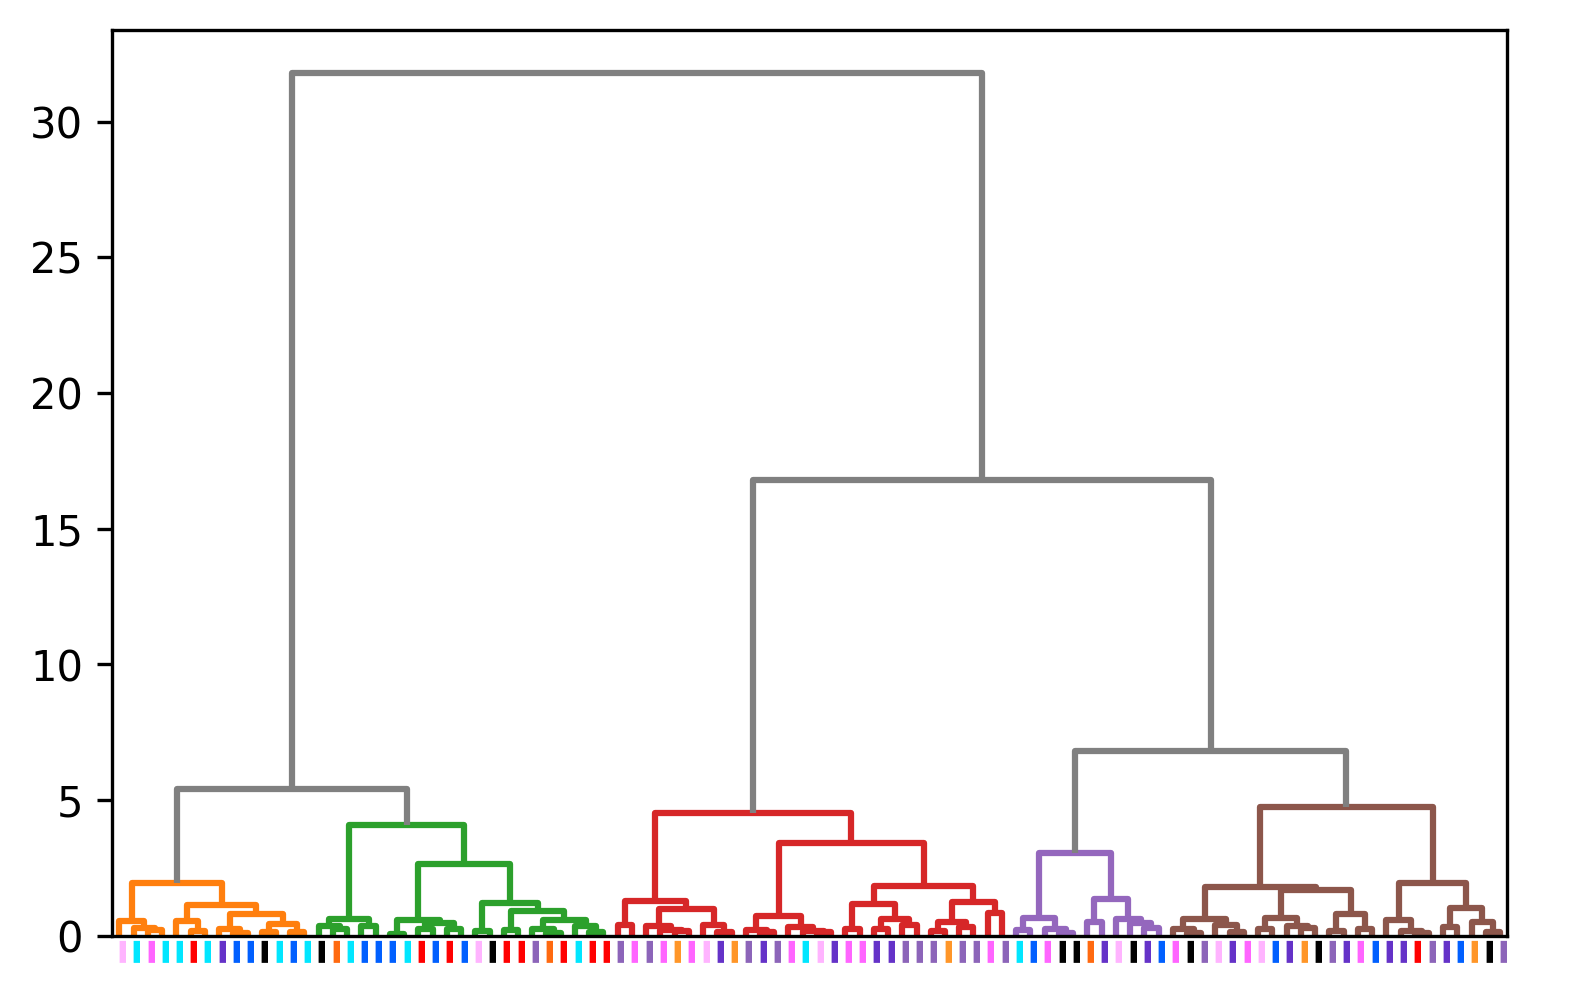

In [21]:
# CHANGE this to 20 for group_size 20
gs = 1
group = pk.load(open('../data/ephys_Germany/Groupings/Groupings_%s.pkl'%gs,'rb'))
pccs = group['pccs']
results = group['results']
neural_groupings = [r[4] for r in results]
aris = np.array([r[1] for r in results])
umaps_neur = [r[2] for r in results]
cts = [r[-1] for r in results]
calltypes_orig = np.asarray([x.split('_')[2] for x in stims])

# take a random grouping in the top 95% of all groupings of this size
pcen = np.percentile(aris,95)
ind = np.random.choice(np.where(aris>pcen)[0])

plt.figure(figsize= (6,4),dpi=300)
plt.scatter(umaps_neur[ind][has_wavs,0],umaps_neur[ind][has_wavs,1],c=[callColor.get(x) for x in calltypes_orig[has_wavs]],s=100)
plt.savefig("Figs/Group%smax_labels.eps"%gs,transparent=True)

plt.figure(figsize= (6,4),dpi=300)
plt.scatter(umaps_neur[ind][has_wavs,0],umaps_neur[ind][has_wavs,1],c=aud_lab,s=100)
plt.savefig("Figs/Group%smax.eps"%gs,transparent=True)

clustered=linkage(umaps_neur[ind][has_wavs,:],method ='ward')
plt.figure(figsize= (6,4),dpi=300)
D = dendrogram(Z=clustered, leaf_rotation=90.,
     leaf_font_size=20., # determine number by plotting cluster colors on leaves first
     #labels= results[max_ari_ind][1], #finesem_calls[1:7633],
     labels=calltypes_orig[has_wavs], #voc_types,#plottinglabels,
     color_threshold= cts[ind],
     above_threshold_color='grey')
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
newlab = []
for t in xlbls:
    t.set_color(callColor.get(t.get_text(),(0,0,0)))
    newlab.append('-')
ax.set_xticklabels(newlab)
ax.tick_params(axis="x",direction="in", pad=-1)

#plt.savefig("Figs/Group%sdend.eps"%gs,transparent = True)

## FET Comments:
1. I assuming that this looks better than the same plot using the PC.s of the responses?
2. What is somewhat surprising is that the Bayesian decoder can do very well for stimuli suchs as song but here it is quite spread out?
3. Maybe we need to look at 3 dimensions to see the actual clusters?  It might make sense that the dimensionality of this neural space is higher than 2?  (I think that there is some interresting stuff to think about in terms of dimensionality of stimulus space vs neural space but that's another topic)
4. We had talked about "helping the viewer" by drawing boundary lines for the clusters - for example, one could run a DFA (or QDA or RF) in this space (supervised clustering) and show those boundaries like in the BioSound tutorials?
5. I have mixed feelings about the comparison with the xy coordinates of the UMAP.  On the POSITIVE side:  It is a form of ensemble tuning curve for complex stimulus space and I think that this is quite cool!!!  To illustrate that maybe this is a place where this analysis should be done with 1, 5, 10, 20 neurons...  BUT I would also explore a blured version - for example, we could do a convolution of the x (color) and y (color) coordinates of the sound with a 2d gaussian based on the x and y of UMAP of the response centered at is position.  The (0.5, 0,0) color (the value if you are far from all points) would correspond to no data. If that's hard (or ugly light reddish) to see maybe you set that at some grey level (it decays to 0.2, 0.2, 0.2) - we are trying to do something like a mean curve (not sure how we would do error bars...) but it is a 2d to 2d representation - so we can not do 3d.  (I guess we could do 3d with a surface that is colored)
6. OK - as I was writting 5, I am thinking about tuning curves... In a classical tuning curve, the x axis is the stimulus and the y axis is the response...  Here we have 2d for stim and 2d for response.  We are trying to use the 2d of the reponse as our axes but maybe it makes more intuitive sense to use the 2d of the stimulus as axis.  So we would plot the neural response on the umap shown in panel 1....  But I think you tried that as well and it was not that great?  I don't remember now.  We could try again with the blurred/mean version suggested in 5.  But where we use colors to represent the neural response (maybe 3 colors for the first 3 dimensions of the UMAP or PC).
7. Finally to make this part of the analysis more in sync with Panel 5, we could do the plots described in 5 with the auditory clusters instead of the x,y coordinates.  That would help explain what we do in 5.

## Panel 5 ARI Calltype vs ARI auditory cluster labels

Then I take the Groupings file (where I calculated ari vs calltype labels based on clustering of the neural data pcs). For each grouping from that tree (neural_groupings below) I calculate the ari for that grouping based on the labels assigned from the hac on the auditory calls based on UMAPS. After this is said and done, ari_neural_vs_aud is this ari, and ari_calltype is the ari based on the neural clustering labeled by calltype (calculated above)

In [28]:
# CALCULATE ari_neural_vs_aud

import glob,time
import pickle as pk
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score

groups = glob.glob("../data/ephys_Germany/Groupings/Groupings_*.pkl")
# make a dataframe for easy processing

# make a dataframe for easy processing
dfout = dict({
    'ari_calltype': [],
    'pcc_bayes': [],
    'group_size': [],
    'neural_grouping': [],
    'ari_neural_vs_aud': []})


# go through all group sizes
for gi, group_fp in enumerate(groups):
    # get basic info for this group size, like pccs, aris (vs calltypes)
    group = pk.load(open(group_fp,'rb'))
    pccs = group['pccs']
    results = group['results']
    aris = [r[1] for r in results]
    dfout['ari_calltype'].extend(aris)
    dfout['pcc_bayes'].extend(pccs)
    dfout['group_size'].extend([len(groupings[gi][0])]*len(pccs))
    
    group = pk.load(open(group_fp,'rb'))
    pccs = group['pccs']
    results = group['results']
    neural_groupings = []#[r[4] for r in results]
    n_v_a_aris = []
    # go through all groupings (of sites)
    for result in results:
        all_groupings = result[3]
        aris = []
        # Go through all cuts of the HAC
        for grouping in all_groupings:
            aris.append(adjusted_rand_score(grouping[has_wavs],aud_lbl_umap))
            
        n_v_a_aris.append(max(aris))
        neural_groupings.append(all_groupings[np.argmax(aris)])
    dfout['neural_grouping'].extend(neural_groupings)
    dfout['ari_neural_vs_aud'].extend(n_v_a_aris)


dfout_f = pd.DataFrame(dfout)
dfout_f.to_hdf("../data/ephys_Germany/Groupings_metadata.hdf","data")

#dfout_f.to_hdf("../data/ephys_Germany/Groupings_metadata_with_ng.hdf",'data')

Starting ../data/ephys_Germany/Groupings/Groupings_1.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_1.pkl in 1.045633316040039
Starting ../data/ephys_Germany/Groupings/Groupings_2.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_2.pkl in 49.659210443496704
Starting ../data/ephys_Germany/Groupings/Groupings_3.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_3.pkl in 98.24960350990295
Starting ../data/ephys_Germany/Groupings/Groupings_4.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_4.pkl in 96.93987941741943
Starting ../data/ephys_Germany/Groupings/Groupings_5.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_5.pkl in 97.3609037399292
Starting ../data/ephys_Germany/Groupings/Groupings_10.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_10.pkl in 97.26988387107849
Starting ../data/ephys_Germany/Groupings/Groupings_20.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_20.pkl in 95.91182231903076


/auto/fhome/lthomas/.virtualenvs/py39/lib/python3.9/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['neural_grouping'], dtype='object')]

  pytables.to_hdf(


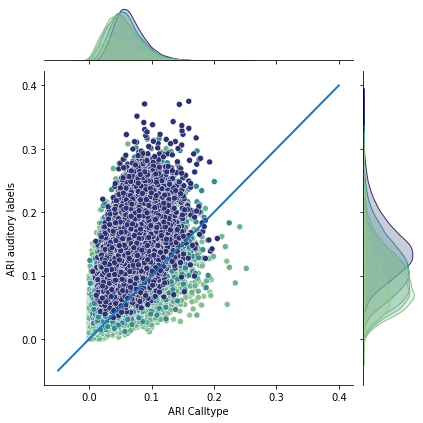

In [35]:
plot = seaborn.jointplot(x='ari_neural_vs_aud',y='ari_calltype',hue='group_size',data=dfout_f,palette='crest')
plot.ax_joint.plot([-.05,.4], [-.05,.4], linewidth = 2)
plot.set_axis_labels("ARI Calltype","ARI auditory labels")
plot.ax_joint.get_legend().set_visible(False)
plt.savefig("Figs/Ari_Aud_vs_calltype.pdf")


## FET Comments
1. I like this we need to get to here so that we can explain but maybe just two or three plots side by side showing the analysis for 4, 12 and 20...

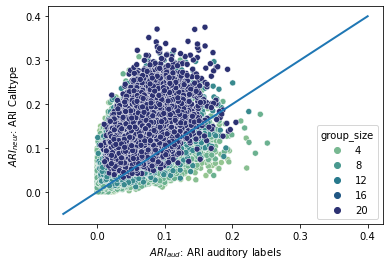

In [36]:
plot = seaborn.scatterplot(x='ari_neural_vs_aud',y='ari_calltype',hue='group_size',data=dfout_f,palette='crest')
plot.axes.plot([-.05,.4], [-.05,.4], linewidth = 2)
plot.set_xlabel(r'$ARI_{aud}$: ARI auditory labels')
plot.set_ylabel( r'$ARI_{neur}$: ARI Calltype')
plt.savefig("Figs/Ari_Aud_vs_calltype.pdf",transparent=True)

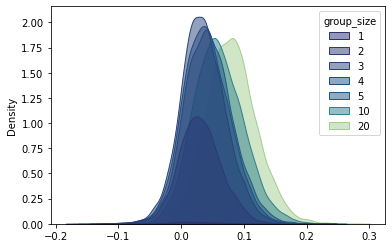

In [37]:
seaborn.kdeplot(x=dfout_f['ari_calltype'] - dfout_f['ari_neural_vs_aud'],hue=dfout_f['group_size'],fill=True,
   alpha=.5,palette='crest_r')
plt.savefig("Figs/Ari_Aud_vs_calltype_hist.pdf")

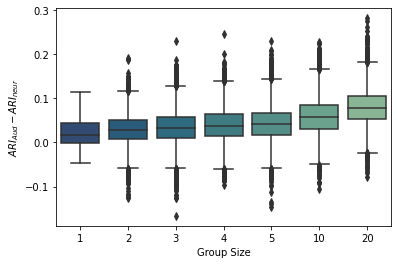

In [38]:
seaborn.boxplot(x=dfout_f['group_size'],y=dfout_f['ari_calltype'] - dfout_f['ari_neural_vs_aud'],palette='crest_r')
plt.ylabel(r'$ARI_{Aud} - ARI_{neur}$')
plt.xlabel('Group Size')
plt.savefig("Figs/Ari_Aud_vs_calltype_box.pdf",transparent=True)

## FET COmments:
1. Nothing wrong with this one - not sure it is needed... Maybe in supplemental methods.